In [2]:
import json
import numpy as np
from math import log
import pandas as pd

# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)


In [3]:
# Let's load one result to see
def normalized_cluster_entropy(counts: pd.Series, n_clusters: int) -> float:
    """Return entropy-based dispersion score in [0, 1] for cluster counts."""
    probs = counts.values / counts.values.sum()
    entropy = -np.sum(probs * np.log10(probs + 1e-12))
    max_entropy = log(n_clusters) if n_clusters > 1 else 1.0
    return float(entropy / max_entropy) if max_entropy > 0 else 0.0



In [4]:
import pandas as pd
import os 
import glob
# Check full models
patient_cluster_stats = []

for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                              config['retrained_model_list2_type']],
                                             [config['retrained_model_list1'],
                                              config['retrained_model_list2']],
                                             [config['retrained_benchmark_folder1'],
                                              config['retrained_benchmark_folder2']]):
    invasive_path = os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans")                                          
    optimal_clusters = pd.read_csv(os.path.join(invasive_path, "optimal_clusters.csv"), index_col=0)

    for name in names:
        filename = glob.glob(os.path.join(invasive_path, name, f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
        df = pd.read_csv(filename, index_col=0)

        df["patient"] = df.index.str.split("_").str[0]
        df["type"] = ["spot" if "spot" in idx else "patch" for idx in df.index]
        patient_with_low_invasive_cancer = df.value_counts("patient")[df.value_counts("patient") < 100].index.tolist()
        df = df[~df["patient"].isin(patient_with_low_invasive_cancer)]
        df = df[df["type"] == "spot"]

        n_global_clusters = df["predicted_label"].nunique()
        if n_global_clusters == 0:
            raise ValueError("No predicted_label values found in the dataframe after filtering.")


        for patient, group in df.groupby("patient"):
            cluster_counts = group["predicted_label"].value_counts()
            diversity_score = normalized_cluster_entropy(cluster_counts, n_global_clusters)
            patient_cluster_stats.append({
                "patient": patient,
                "cluster_diversity_score": diversity_score,
                "n_clusters_present": int(cluster_counts.size),
                "dominant_cluster": cluster_counts.idxmax(),
                "model": name
            })



In [5]:
cluster_repartition_df = pd.DataFrame(patient_cluster_stats).sort_values("cluster_diversity_score", ascending=False)
cluster_repartition_df

,patient,cluster_diversity_score,n_clusters_present,dominant_cluster,model
843,TNBC49,3.747215e-01,5,1,uni_full_koleo_16384_prototypes
651,TNBC49,3.610398e-01,5,2,uni_full_kde_16384_prototypes
864,TNBC78,3.559357e-01,6,1,uni_full_koleo_16384_prototypes
357,TNBC20,3.523621e-01,4,0,uni_explora_koleo_16384_prototypes
927,TNBC78,3.498735e-01,5,0,uni_full_koleo_65536_prototypes
...,...,...,...,...,...
589,TNBC53,-3.133051e-13,1,1,uni_full_kde_4096_prototypes
606,TNBC76,-3.133051e-13,1,0,uni_full_kde_4096_prototypes
728,TNBC62,-3.133051e-13,1,0,uni_full_kde_65536_prototypes
736,TNBC73,-3.133051e-13,1,3,uni_full_kde_65536_prototypes


In [6]:
import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

retrained_models = config['retrained_model_list1'] + config['retrained_model_list2']
sorted_retrained_models = sort_retrained_models(retrained_models)

palette = []
for model in sorted_retrained_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

In [7]:
# order models according to sorted_retrained_models, keep any extra models at the end
model_order = [m for m in sorted_retrained_models if m in cluster_repartition_df['model'].unique()]
extra_models = [m for m in cluster_repartition_df['model'].unique() if m not in model_order]
categories = model_order + extra_models

cluster_repartition_df['model'] = pd.Categorical(cluster_repartition_df['model'], categories=categories, ordered=True)
cluster_repartition_df = cluster_repartition_df.sort_values('model').reset_index(drop=True)

cluster_repartition_df

,patient,cluster_diversity_score,n_clusters_present,dominant_cluster,model
0,TNBC59,0.044777,4,2,uni
1,TNBC83,0.038231,4,1,uni
2,TNBC37,0.142485,4,2,uni
3,TNBC83,0.038231,4,1,uni
4,TNBC46,0.060111,4,3,uni
...,...,...,...,...,...
938,TNBC31,0.113153,4,4,uni_full_koleo_65536_prototypes
939,TNBC92,0.309865,5,0,uni_full_koleo_65536_prototypes
940,TNBC93,0.113146,5,3,uni_full_koleo_65536_prototypes
941,TNBC61,0.014518,2,1,uni_full_koleo_65536_prototypes


/tmp/ipykernel_1710230/4095593488.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cluster_repartition_df, y="cluster_diversity_score", x='model', palette=palette,


Text(0.5, 1.0, 'Shannon entropy of cluster distributions across patients')

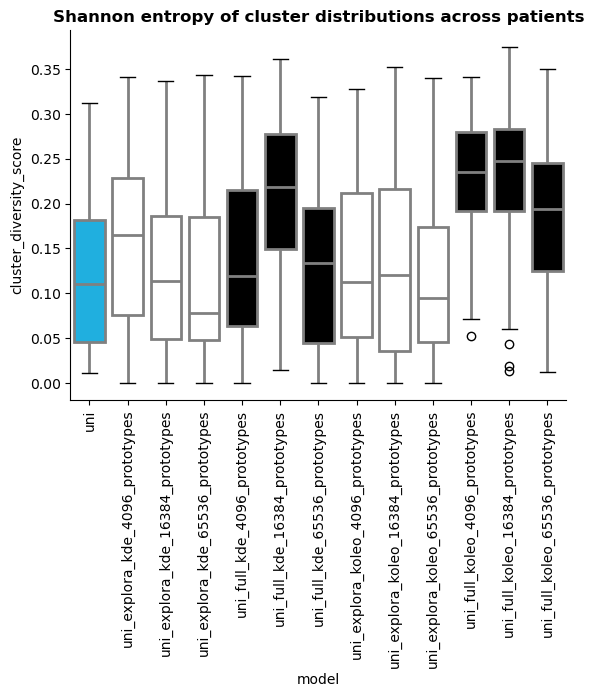

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=cluster_repartition_df, y="cluster_diversity_score", x='model', palette=palette, 
            boxprops=dict(edgecolor='gray', linewidth=2), 
            medianprops=dict(color='gray', linewidth=2),
            whiskerprops=dict(color='gray', linewidth=2))
plt.xticks(rotation=90);
sns.despine()
plt.title("Shannon entropy of cluster distributions across patients", weight='bold')